In [ ]:
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

from IPython.display import Image
from keras.utils import plot_model


from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Activation,Conv2D,MaxPooling2D,GlobalAveragePooling2D, Flatten,Dropout,Dense
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import TensorBoard as tb
from keras.preprocessing.image import img_to_array, load_img
from keras import preprocessing
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import cv2 as cv2


import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

/Users/andrerodrigues/opt/miniconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andrerodrigues/opt/miniconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andrerodrigues/opt/miniconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/andrer

## 1) Checking Keras and Tensorflow versions

In [3]:
print(keras.__version__)

2.2.4


In [4]:
print(tf.__version__)

1.13.1


## 2) Importing and separating train, validation and test datasets

In [5]:
BS = 64
IMAGE_DIMS = (50,50,3)
EPOCHS = 100
VALID_PERC = 0.2
Dataset_Train = '../Exercicio8_fruits/fruits-360_dataset/fruits-360/Training'
Dataset_Test = '../Exercicio8_fruits/fruits-360_dataset/fruits-360/Test'
save_file = 'Fruits_v01.hdf'
log_path = '../Exercicio8_fruits'

In [6]:
# data augmentation: prevent further overfit by randomly transforming the training images
train_datagen = preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split=VALID_PERC # set validation split
)

train_generator = train_datagen.flow_from_directory(
    Dataset_Train,
    batch_size=BS,
    color_mode='rgb' if IMAGE_DIMS[2]==3 else 'grayscale',
    seed=42,
    class_mode="categorical",
    shuffle=True,
    subset='training',
    target_size=(IMAGE_DIMS[0],IMAGE_DIMS[1])
)

validation_generator = train_datagen.flow_from_directory(
    Dataset_Train,
    batch_size=BS,
    color_mode='rgb' if IMAGE_DIMS[2]==3 else 'grayscale',
    seed=42,
    class_mode="categorical",
    shuffle=True,
    subset='validation',
    target_size=(IMAGE_DIMS[0],IMAGE_DIMS[1])
)


test_datagen = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)


test_generator = test_datagen.flow_from_directory(
    Dataset_Test,
    batch_size=1,
    color_mode='rgb' if IMAGE_DIMS[2]==3 else 'grayscale',
    seed=42,
    class_mode=None,
    shuffle=False,
    target_size=(IMAGE_DIMS[0],IMAGE_DIMS[1])
)

Found 48431 images belonging to 120 classes.
Found 12067 images belonging to 120 classes.
Found 20622 images belonging to 120 classes.


In [7]:
categories = train_generator.num_classes
categories

120

## 3) Visualizing Six Train Image Samples

In [8]:
x_train, y_train = train_generator.next()

In [9]:
x_train.shape

(64, 50, 50, 3)

In [10]:
y_train.shape

(64, 120)

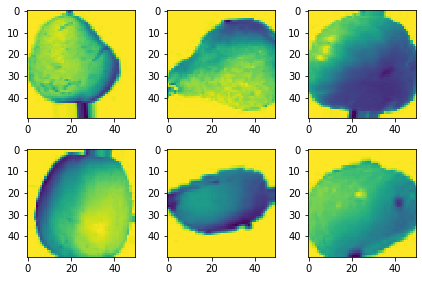

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3)
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()
axlist = [ax0, ax1, ax2, ax3, ax4, ax5]

for i in range(0,6):
    image = x_train[i]
    cv2.imshow('{}_{}'.format(IMAGE_DIMS[0],IMAGE_DIMS[1]), image[:,:,0])
    ax = axlist[i]
    ax.imshow(image[:,:,0])
    
fig.tight_layout()
plt.show()

## 5) Building the LeNet-5 Model

![](https://i.ibb.co/L6Tr8s0/LeNet5.png)

In [12]:
model = Sequential()

### a) Convolução 2D com função de ativação tanh 6 filtros de 5x5

In [13]:
model.add(Conv2D(6, (5,5), input_shape=IMAGE_DIMS, padding='same', activation='tanh'))
print(model.output_shape)

Instructions for updating:
Colocations handled automatically by placer.
(None, 50, 50, 6)


#### b) Camada de Pooling

In [14]:
model.add(AveragePooling2D(pool_size=(2,2), strides=(1,1), padding='valid'))

#### c) Convolução 2D com função de ativação tanh 16 filtros de 5x5

In [15]:
model.add(Conv2D(16,(5,5), strides=(1,1), padding='valid', activation='tanh'))
print(model.output_shape)

(None, 45, 45, 16)


#### d) Camada de Pooling

In [16]:
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

#### e) Convolução 2D com função de ativação tanh 120 filtros de 5x5

In [17]:
model.add(Conv2D(120,(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
print(model.output_shape)

(None, 18, 18, 120)


In [18]:
model.add(Dropout(0.5))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### e) Converte o conjunto de imagens num vetor unidimensional para a entrada da Camada Completamente Conectada

In [19]:
model.add(Flatten())

#### f) Adicionamos uma camada completamente conectada, baseada na LeNet5 que começa com mais neurônios na camada inicial e ela vai reduzindo.

In [20]:
model.add(Dense(84, activation='tanh'))
print(model.output_shape)

(None, 84)


In [21]:
model.add(Dropout(0.2))

In [22]:
model.add(Dense(categories, activation='softmax'))
print(model.output_shape)

(None, 120)


## 6) Visualizing the Model

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 6)         456       
_________________________________________________________________
average_pooling2d_1 (Average (None, 49, 49, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 120)       48120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 120)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 38880)             0         
__________

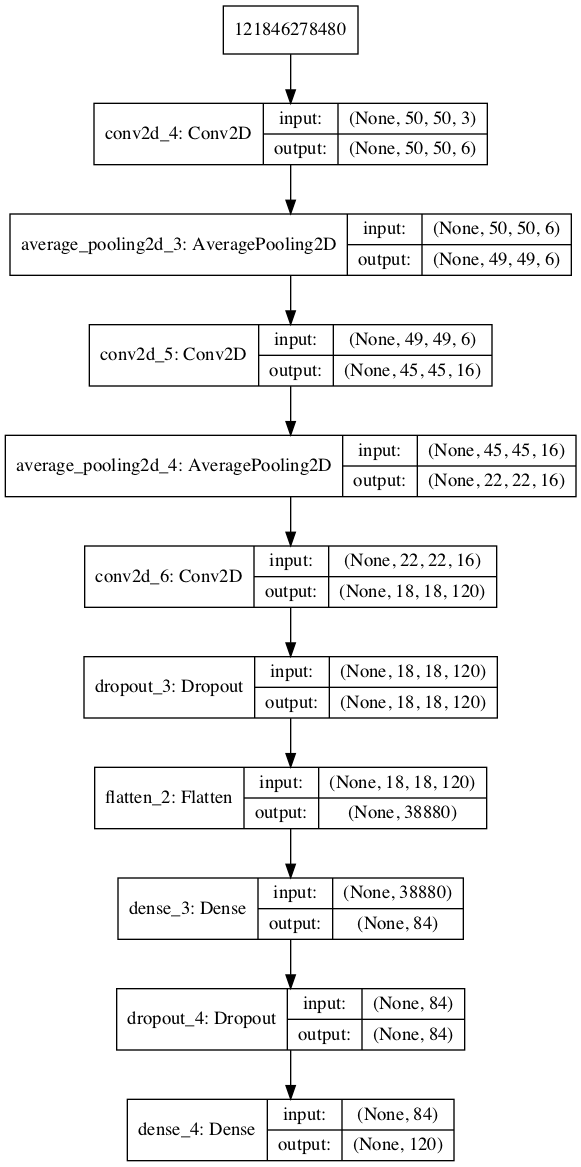

In [57]:
plot_model(model, to_file='cnn-fruits.png', show_shapes=True, show_layer_names=True)
Image('cnn-fruits.png')

## 7) Fitting the Model

### Compila o modelo definindo o SGD optimization como algoritmo de atualização

In [24]:
model.compile(
    loss='categorical_crossentropy'
    ,optimizer='sgd'
    ,metrics=['accuracy']
#     ,mode=['min']
)

In [25]:
tensorboard = tb(
    log_dir=log_path
    ,write_graph=False #This eats a lot of space. Enable with caution!
    #,histogram_freq = 1
    ,write_images=True
    ,batch_size = BS
    ,write_grads=True
)

In [26]:
earlystopper = EarlyStopping(
    monitor='loss'
    ,patience=15
    ,verbose=1
)

In [27]:
checkpointer = ModelCheckpoint(
    save_file
    , verbose = 1
    , save_best_only = True
    , monitor='accuracy'
    , mode='min'
)

In [28]:
callbacks = [checkpointer, earlystopper, tensorboard]

In [29]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TRAIN

756

In [30]:
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
STEP_SIZE_VALID

188

In [31]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
STEP_SIZE_TEST

20622

In [32]:
history = model.fit_generator(
    train_generator
    ,epochs=EPOCHS
    ,steps_per_epoch = STEP_SIZE_TRAIN
    ,validation_data = validation_generator
    ,validation_steps = STEP_SIZE_VALID
    ,callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
756/756 [==============================] - 348s 460ms/step - loss: 3.9326 - acc: 0.0997 - val_loss: 3.2432 - val_acc: 0.2266
Epoch 2/100
756/756 [==============================] - 358s 473ms/step - loss: 2.9099 - acc: 0.2745 - val_loss: 2.5147 - val_acc: 0.4261
Epoch 3/100
756/756 [==============================] - 380s 503ms/step - loss: 2.3189 - acc: 0.4250 - val_loss: 2.0405 - val_acc: 0.5695
Epoch 4/100
756/756 [==============================] - 371s 491ms/step - loss: 1.9115 - acc: 0.5325 - val_loss: 1.7445 - val_acc: 0.6295
Epoch 5/100
756/756 [==============================] - 385s 509ms/step - loss: 1.6144 - acc: 0.6179 - val_loss: 1.4595 - val_acc: 0.6878
Epoch 6/100
756/756 [==============================] - 380s 503ms/step - loss: 1.3819 - acc: 0.6774 - val_loss: 1.2473 - val_acc: 0.7561
Epoch 7/100
756/756 [==============================] - 380s 502ms/step - loss: 1.1961 - acc: 0.7238 - val_loss: 1.1725 - val_acc: 

In [33]:
# # fit model
# history = model.fit_generator(
#     generator=train_generator
#     ,steps_per_epoch=STEP_SIZE_TRAIN
#     ,validation_data=validation_generator
#     ,validation_steps=STEP_SIZE_VALID
#     ,epochs=epochs
#     ,callbacks= callbacks
# #     , class_weight = class_weight
# )

## 8) Saving the Model

In [34]:
model.save(log_path + save_file)

In [35]:
from keras.models import load_model
model = load_model(log_path + save_file)

## 9) Evaluating the Model

In [36]:
scores = model.evaluate_generator(generator=validation_generator, steps=STEP_SIZE_VALID)

In [37]:
print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


loss: 15.28%

acc: 95.62%


### Learning Curves


#### Plot Training & Validation accuracy values

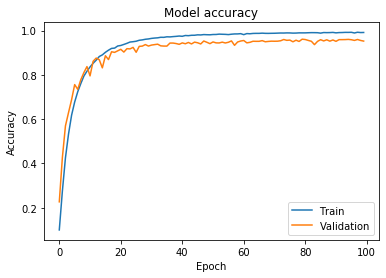

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### Plot Training & Validation losses values

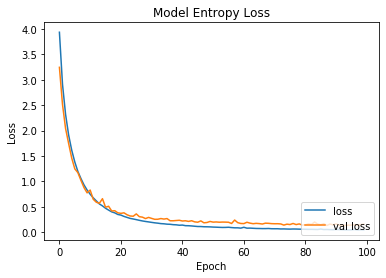

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val loss'], loc='lower right')
plt.show()

## 10) Predicting the output

In [40]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

test_generator.reset()

pred=model.predict_generator(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1
                            )

20622/20622 [==============================] - 138s 7ms/step


In [41]:
pred

array([[9.92283642e-01, 3.47688401e-05, 9.25077437e-09, ...,
        7.14694863e-08, 2.53155372e-06, 1.28217115e-09],
       [9.92362022e-01, 3.47764289e-05, 9.16589737e-09, ...,
        7.04403291e-08, 2.47759340e-06, 1.25893251e-09],
       [9.90696073e-01, 4.48548526e-05, 1.01722915e-08, ...,
        8.50029309e-08, 3.23843483e-06, 1.46171675e-09],
       ...,
       [1.22342425e-09, 4.17324308e-08, 1.07767297e-08, ...,
        1.24825470e-04, 1.64710756e-09, 9.98532414e-01],
       [1.08796017e-09, 4.43615598e-08, 1.02782707e-08, ...,
        1.25369290e-04, 1.67282632e-09, 9.98470008e-01],
       [1.26391619e-09, 4.13197405e-08, 1.10270229e-08, ...,
        1.23925551e-04, 1.67476510e-09, 9.98539090e-01]], dtype=float32)

In [42]:
pred.shape

(20622, 120)

In [43]:
predicted_class_indices=np.argmax(pred,axis=1) # Returns the indices of the maximum values along an axis.
predicted_class_indices

array([  0,   0,   0, ..., 119, 119, 119])

In [44]:
labels = (train_generator.class_indices)
labels

{'Apple Braeburn': 0,
 'Apple Crimson Snow': 1,
 'Apple Golden 1': 2,
 'Apple Golden 2': 3,
 'Apple Golden 3': 4,
 'Apple Granny Smith': 5,
 'Apple Pink Lady': 6,
 'Apple Red 1': 7,
 'Apple Red 2': 8,
 'Apple Red 3': 9,
 'Apple Red Delicious': 10,
 'Apple Red Yellow 1': 11,
 'Apple Red Yellow 2': 12,
 'Apricot': 13,
 'Avocado': 14,
 'Avocado ripe': 15,
 'Banana': 16,
 'Banana Lady Finger': 17,
 'Banana Red': 18,
 'Beetroot': 19,
 'Blueberry': 20,
 'Cactus fruit': 21,
 'Cantaloupe 1': 22,
 'Cantaloupe 2': 23,
 'Carambula': 24,
 'Cauliflower': 25,
 'Cherry 1': 26,
 'Cherry 2': 27,
 'Cherry Rainier': 28,
 'Cherry Wax Black': 29,
 'Cherry Wax Red': 30,
 'Cherry Wax Yellow': 31,
 'Chestnut': 32,
 'Clementine': 33,
 'Cocos': 34,
 'Dates': 35,
 'Eggplant': 36,
 'Ginger Root': 37,
 'Granadilla': 38,
 'Grape Blue': 39,
 'Grape Pink': 40,
 'Grape White': 41,
 'Grape White 2': 42,
 'Grape White 3': 43,
 'Grape White 4': 44,
 'Grapefruit Pink': 45,
 'Grapefruit White': 46,
 'Guava': 47,
 'Hazelnut

In [45]:
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Apple Braeburn',
 1: 'Apple Crimson Snow',
 2: 'Apple Golden 1',
 3: 'Apple Golden 2',
 4: 'Apple Golden 3',
 5: 'Apple Granny Smith',
 6: 'Apple Pink Lady',
 7: 'Apple Red 1',
 8: 'Apple Red 2',
 9: 'Apple Red 3',
 10: 'Apple Red Delicious',
 11: 'Apple Red Yellow 1',
 12: 'Apple Red Yellow 2',
 13: 'Apricot',
 14: 'Avocado',
 15: 'Avocado ripe',
 16: 'Banana',
 17: 'Banana Lady Finger',
 18: 'Banana Red',
 19: 'Beetroot',
 20: 'Blueberry',
 21: 'Cactus fruit',
 22: 'Cantaloupe 1',
 23: 'Cantaloupe 2',
 24: 'Carambula',
 25: 'Cauliflower',
 26: 'Cherry 1',
 27: 'Cherry 2',
 28: 'Cherry Rainier',
 29: 'Cherry Wax Black',
 30: 'Cherry Wax Red',
 31: 'Cherry Wax Yellow',
 32: 'Chestnut',
 33: 'Clementine',
 34: 'Cocos',
 35: 'Dates',
 36: 'Eggplant',
 37: 'Ginger Root',
 38: 'Granadilla',
 39: 'Grape Blue',
 40: 'Grape Pink',
 41: 'Grape White',
 42: 'Grape White 2',
 43: 'Grape White 3',
 44: 'Grape White 4',
 45: 'Grapefruit Pink',
 46: 'Grapefruit White',
 47: 'Guava',
 48: 'Haze

In [46]:
predictions = [labels[k] for k in predicted_class_indices]

In [47]:
filenames=test_generator.filenames
# filenames

In [48]:
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [49]:
results.head(200)

,Filename,Predictions
0,Apple Braeburn/321_100.jpg,Apple Braeburn
1,Apple Braeburn/322_100.jpg,Apple Braeburn
2,Apple Braeburn/323_100.jpg,Apple Braeburn
3,Apple Braeburn/324_100.jpg,Apple Braeburn
4,Apple Braeburn/325_100.jpg,Apple Braeburn
...,...,...
195,Apple Crimson Snow/132_100.jpg,Apple Crimson Snow
196,Apple Crimson Snow/133_100.jpg,Apple Crimson Snow
197,Apple Crimson Snow/134_100.jpg,Apple Crimson Snow
198,Apple Crimson Snow/135_100.jpg,Apple Crimson Snow


In [50]:
results.to_csv("results.csv",index=False)

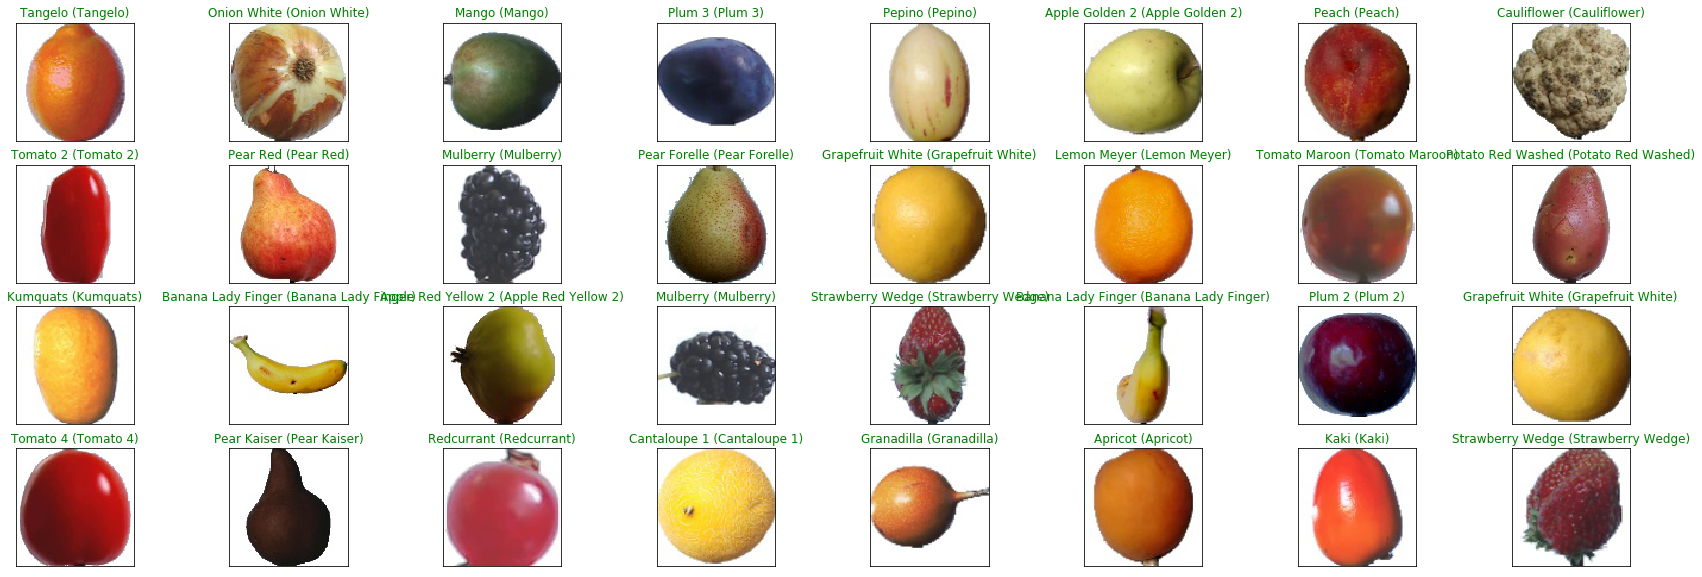

In [51]:
import random
import re

# plot the first 9 images in the planet dataset
from matplotlib import pyplot
from matplotlib.image import imread

# define location of dataset
folder = '../Exercicio8_fruits/fruits-360_dataset/fruits-360/Test/'

# plot first few images
fig = plt.figure(figsize=(30, 10))
for i, idx in enumerate(np.random.choice(results.values.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    filename = folder + results['Filename'][idx]
    image = imread(filename)
    ax.imshow(image)
    pred_idx = results['Predictions'][idx]
    true_idx = re.sub(r'/.*$',"",results['Filename'][idx])
    ax.set_title("{} ({})".format(pred_idx, true_idx),
                 color=("green" if pred_idx == true_idx else "red"))

#### Notamos um overfitting que corregiremos aumentando o Dropout

## Corrigindo o modelo

In [12]:
model = Sequential()

### a) Convolução 2D com função de ativação tanh 6 filtros de 5x5

In [13]:
model.add(Conv2D(6, (5,5), input_shape=IMAGE_DIMS, padding='same', activation='tanh'))
print(model.output_shape)

Instructions for updating:
Colocations handled automatically by placer.
(None, 50, 50, 6)


#### b) Camada de Pooling

In [14]:
model.add(AveragePooling2D(pool_size=(2,2), strides=(1,1), padding='valid'))

In [15]:
model.add(Dropout(0.5))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### c) Convolução 2D com função de ativação tanh 16 filtros de 5x5

In [16]:
model.add(Conv2D(16,(5,5), strides=(1,1), padding='valid', activation='tanh'))
print(model.output_shape)

(None, 45, 45, 16)


#### d) Camada de Pooling

In [17]:
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

#### e) Convolução 2D com função de ativação tanh 120 filtros de 5x5

In [18]:
model.add(Conv2D(120,(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
print(model.output_shape)

(None, 18, 18, 120)


In [19]:
model.add(Dropout(0.5))

#### e) Converte o conjunto de imagens num vetor unidimensional para a entrada da Camada Completamente Conectada

In [20]:
model.add(Flatten())

#### f) Adicionamos uma camada completamente conectada, baseada na LeNet5 que começa com mais neurônios na camada inicial e ela vai reduzindo.

In [21]:
model.add(Dense(84, activation='tanh'))
print(model.output_shape)

(None, 84)


In [22]:
model.add(Dropout(0.5))

In [23]:
model.add(Dense(categories, activation='softmax'))
print(model.output_shape)

(None, 120)


## 6) Visualizing the Model

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 6)         456       
_________________________________________________________________
average_pooling2d_1 (Average (None, 49, 49, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 120)       48120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 18, 120)       0         
__________

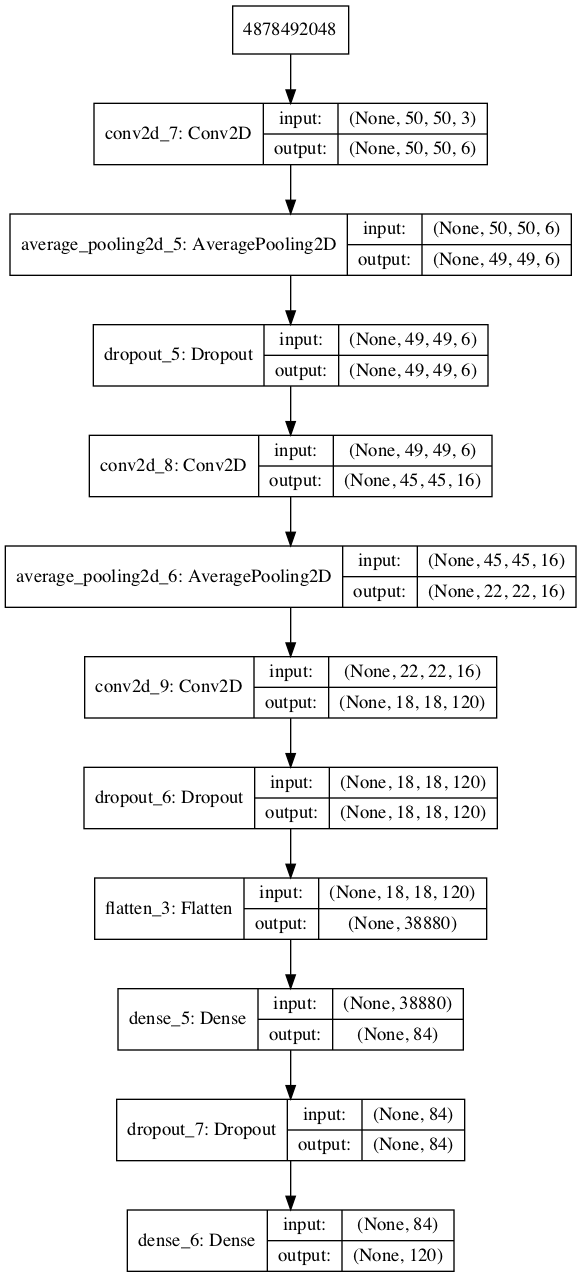

In [80]:
plot_model(model, to_file='cnn-fruits_2.png', show_shapes=True, show_layer_names=True)
Image('cnn-fruits_2.png')

## 7) Fitting the Model

### Compila o modelo definindo o SGD optimization como algoritmo de atualização

In [25]:
model.compile(
    loss='categorical_crossentropy'
    ,optimizer='sgd'
    ,metrics=['accuracy']
#     ,mode=['min']
)

In [26]:
tensorboard = tb(
    log_dir=log_path
    ,write_graph=False #This eats a lot of space. Enable with caution!
    #,histogram_freq = 1
    ,write_images=True
    ,batch_size = BS
    ,write_grads=True
)

In [27]:
earlystopper = EarlyStopping(
    monitor='loss'
    ,patience=15
    ,verbose=1
)

In [28]:
checkpointer = ModelCheckpoint(
    save_file
    , verbose = 1
    , save_best_only = True
    , monitor='accuracy'
    , mode='min'
)

In [29]:
callbacks = [checkpointer, earlystopper, tensorboard]

In [30]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TRAIN

756

In [31]:
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
STEP_SIZE_VALID

188

In [32]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
STEP_SIZE_TEST

20622

In [33]:
history = model.fit_generator(
    train_generator
    ,epochs=EPOCHS
    ,steps_per_epoch = STEP_SIZE_TRAIN
    ,validation_data = validation_generator
    ,validation_steps = STEP_SIZE_VALID
    ,callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
756/756 [==============================] - 403s 533ms/step - loss: 4.0952 - acc: 0.0752 - val_loss: 3.1720 - val_acc: 0.2699
Epoch 2/100
756/756 [==============================] - 408s 539ms/step - loss: 3.1186 - acc: 0.2003 - val_loss: 2.5616 - val_acc: 0.4043
Epoch 3/100
756/756 [==============================] - 399s 528ms/step - loss: 2.5927 - acc: 0.3008 - val_loss: 2.1384 - val_acc: 0.5177
Epoch 4/100
756/756 [==============================] - 400s 529ms/step - loss: 2.2226 - acc: 0.3854 - val_loss: 1.7873 - val_acc: 0.6045
Epoch 5/100
756/756 [==============================] - 396s 524ms/step - loss: 1.9479 - acc: 0.4561 - val_loss: 1.6198 - val_acc: 0.6219
Epoch 6/100
756/756 [==============================] - 401s 530ms/step - loss: 1.7292 - acc: 0.5159 - val_loss: 1.3764 - val_acc: 0.7132
Epoch 7/100
756/756 [==============================] - 427s 565ms/step - loss: 1.5546 - acc: 0.5704 - val_loss: 1.2332 - val_acc: 

In [34]:
# # fit model
# history = model.fit_generator(
#     generator=train_generator
#     ,steps_per_epoch=STEP_SIZE_TRAIN
#     ,validation_data=validation_generator
#     ,validation_steps=STEP_SIZE_VALID
#     ,epochs=epochs
#     ,callbacks= callbacks
# #     , class_weight = class_weight
# )

## 8) Saving the Model

In [35]:
model.save(log_path + save_file)

In [36]:
from keras.models import load_model
model = load_model(log_path + save_file)

## 9) Evaluating the Model

In [37]:
scores = model.evaluate_generator(generator=validation_generator, steps=STEP_SIZE_VALID)

In [38]:
print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


loss: 19.43%

acc: 94.67%


### Learning Curves


#### Plot Training & Validation accuracy values

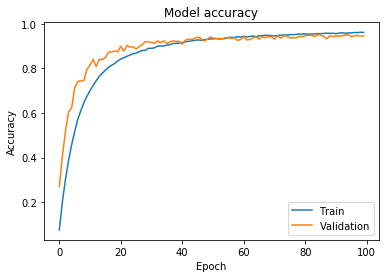

In [39]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### Plot Training & Validation losses values

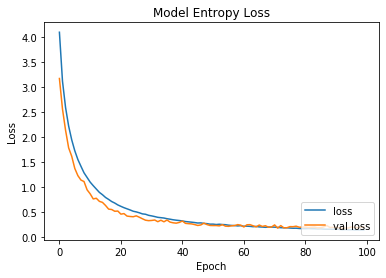

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val loss'], loc='lower right')
plt.show()

## 10) Predicting the output

In [41]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

test_generator.reset()

pred=model.predict_generator(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1
                            )

20622/20622 [==============================] - 142s 7ms/step


In [42]:
pred

array([[9.92030025e-01, 4.74803994e-04, 1.29701592e-08, ...,
        1.47487370e-07, 1.04439630e-08, 1.00581765e-09],
       [9.92298186e-01, 3.82656406e-04, 1.35073925e-08, ...,
        1.41505581e-07, 1.00943076e-08, 8.42580894e-10],
       [9.90980089e-01, 7.25977123e-04, 1.90451388e-08, ...,
        2.02655301e-07, 1.64147735e-08, 1.38223022e-09],
       ...,
       [1.58290964e-10, 5.34770344e-08, 1.23062991e-08, ...,
        2.82685323e-05, 1.35745171e-09, 9.95950580e-01],
       [1.88673896e-10, 6.17659950e-08, 5.26452348e-09, ...,
        1.39918493e-05, 8.17117762e-10, 9.97251213e-01],
       [1.64231767e-10, 5.47789121e-08, 1.10487459e-08, ...,
        2.56649255e-05, 1.28013722e-09, 9.96140063e-01]], dtype=float32)

In [43]:
pred.shape

(20622, 120)

In [44]:
predicted_class_indices=np.argmax(pred,axis=1) # Returns the indices of the maximum values along an axis.
predicted_class_indices

array([  0,   0,   0, ..., 119, 119, 119])

In [45]:
labels = (train_generator.class_indices)
labels

{'Apple Braeburn': 0,
 'Apple Crimson Snow': 1,
 'Apple Golden 1': 2,
 'Apple Golden 2': 3,
 'Apple Golden 3': 4,
 'Apple Granny Smith': 5,
 'Apple Pink Lady': 6,
 'Apple Red 1': 7,
 'Apple Red 2': 8,
 'Apple Red 3': 9,
 'Apple Red Delicious': 10,
 'Apple Red Yellow 1': 11,
 'Apple Red Yellow 2': 12,
 'Apricot': 13,
 'Avocado': 14,
 'Avocado ripe': 15,
 'Banana': 16,
 'Banana Lady Finger': 17,
 'Banana Red': 18,
 'Beetroot': 19,
 'Blueberry': 20,
 'Cactus fruit': 21,
 'Cantaloupe 1': 22,
 'Cantaloupe 2': 23,
 'Carambula': 24,
 'Cauliflower': 25,
 'Cherry 1': 26,
 'Cherry 2': 27,
 'Cherry Rainier': 28,
 'Cherry Wax Black': 29,
 'Cherry Wax Red': 30,
 'Cherry Wax Yellow': 31,
 'Chestnut': 32,
 'Clementine': 33,
 'Cocos': 34,
 'Dates': 35,
 'Eggplant': 36,
 'Ginger Root': 37,
 'Granadilla': 38,
 'Grape Blue': 39,
 'Grape Pink': 40,
 'Grape White': 41,
 'Grape White 2': 42,
 'Grape White 3': 43,
 'Grape White 4': 44,
 'Grapefruit Pink': 45,
 'Grapefruit White': 46,
 'Guava': 47,
 'Hazelnut

In [46]:
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Apple Braeburn',
 1: 'Apple Crimson Snow',
 2: 'Apple Golden 1',
 3: 'Apple Golden 2',
 4: 'Apple Golden 3',
 5: 'Apple Granny Smith',
 6: 'Apple Pink Lady',
 7: 'Apple Red 1',
 8: 'Apple Red 2',
 9: 'Apple Red 3',
 10: 'Apple Red Delicious',
 11: 'Apple Red Yellow 1',
 12: 'Apple Red Yellow 2',
 13: 'Apricot',
 14: 'Avocado',
 15: 'Avocado ripe',
 16: 'Banana',
 17: 'Banana Lady Finger',
 18: 'Banana Red',
 19: 'Beetroot',
 20: 'Blueberry',
 21: 'Cactus fruit',
 22: 'Cantaloupe 1',
 23: 'Cantaloupe 2',
 24: 'Carambula',
 25: 'Cauliflower',
 26: 'Cherry 1',
 27: 'Cherry 2',
 28: 'Cherry Rainier',
 29: 'Cherry Wax Black',
 30: 'Cherry Wax Red',
 31: 'Cherry Wax Yellow',
 32: 'Chestnut',
 33: 'Clementine',
 34: 'Cocos',
 35: 'Dates',
 36: 'Eggplant',
 37: 'Ginger Root',
 38: 'Granadilla',
 39: 'Grape Blue',
 40: 'Grape Pink',
 41: 'Grape White',
 42: 'Grape White 2',
 43: 'Grape White 3',
 44: 'Grape White 4',
 45: 'Grapefruit Pink',
 46: 'Grapefruit White',
 47: 'Guava',
 48: 'Haze

In [47]:
predictions = [labels[k] for k in predicted_class_indices]

In [48]:
filenames=test_generator.filenames
# filenames

In [49]:
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [50]:
results.head(200)

,Filename,Predictions
0,Apple Braeburn/321_100.jpg,Apple Braeburn
1,Apple Braeburn/322_100.jpg,Apple Braeburn
2,Apple Braeburn/323_100.jpg,Apple Braeburn
3,Apple Braeburn/324_100.jpg,Apple Braeburn
4,Apple Braeburn/325_100.jpg,Apple Braeburn
...,...,...
195,Apple Crimson Snow/132_100.jpg,Apple Crimson Snow
196,Apple Crimson Snow/133_100.jpg,Apple Crimson Snow
197,Apple Crimson Snow/134_100.jpg,Apple Crimson Snow
198,Apple Crimson Snow/135_100.jpg,Apple Crimson Snow


In [51]:
results.to_csv("results.csv",index=False)

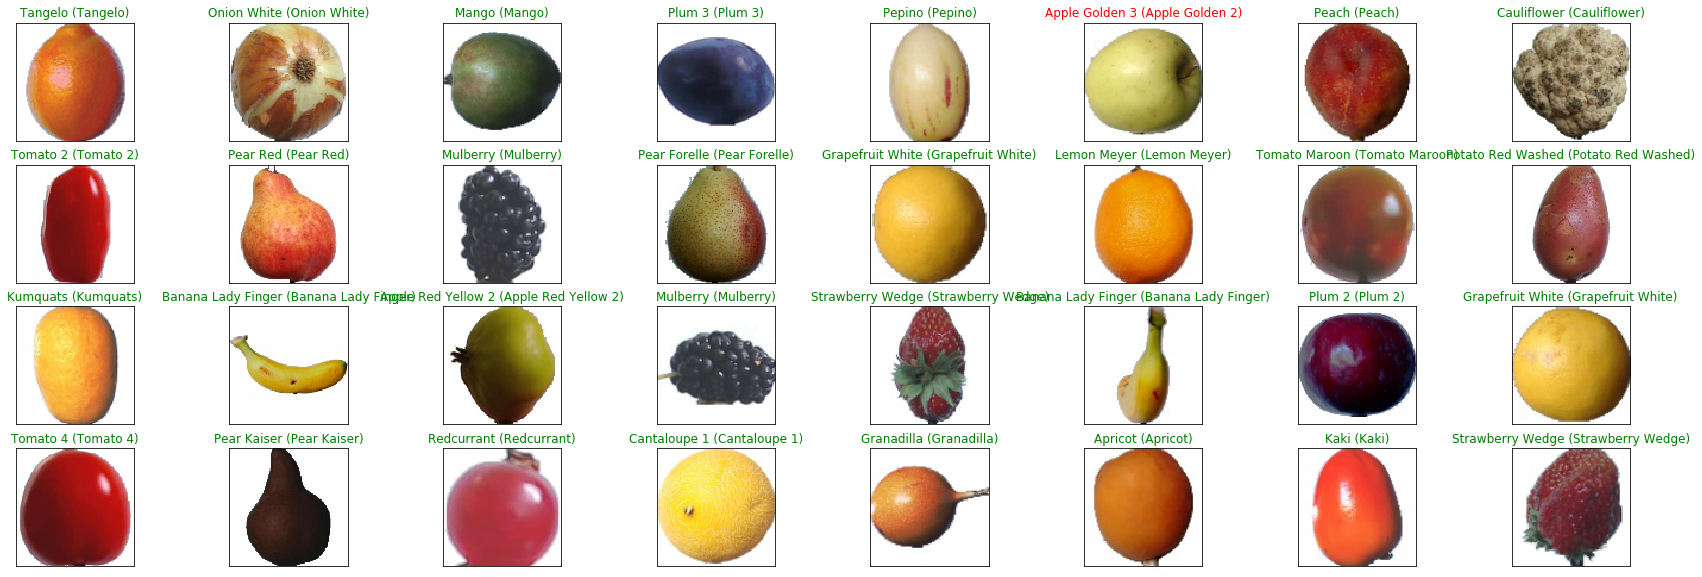

In [52]:
import random
import re

# plot the first 9 images in the planet dataset
from matplotlib import pyplot
from matplotlib.image import imread

# define location of dataset
folder = '../Exercicio8_fruits/fruits-360_dataset/fruits-360/Test/'

# plot first few images
fig = plt.figure(figsize=(30, 10))
for i, idx in enumerate(np.random.choice(results.values.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    filename = folder + results['Filename'][idx]
    image = imread(filename)
    ax.imshow(image)
    pred_idx = results['Predictions'][idx]
    true_idx = re.sub(r'/.*$',"",results['Filename'][idx])
    ax.set_title("{} ({})".format(pred_idx, true_idx),
                 color=("green" if pred_idx == true_idx else "red"))

#### References:

##### Horea Muresan, [Mihai Oltean](https://mihaioltean.github.io), [Fruit recognition from images using deep learning](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning), Acta Univ. Sapientiae, Informatica Vol. 10, Issue 1, pp. 26-42, 2018.

##### https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/

##### https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

##### https://www.kaggle.com/akhilvjose/cnn-keras-acc-above90


##### https://engmrk.com/lenet-5-a-classic-cnn-architecture/


##### http://sigmoidal.ai/redes-neurais-convolucionais-python/


##### https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator


##### https://keras.io/preprocessing/image/